# Example 3

It's an example with chain PCA -> EDR-GP

In [ ]:
import sys
import os.path as op
sys.path = [op.abspath('../')] + sys.path + [op.abspath('../')]

In [1]:
import regression
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy

In [3]:
from sklearn.decomposition import PCA, SparsePCA
from edrgp.utils import CustomPCA
from edrgp.gp_model import GaussianProcessRegressor
from edrgp import EffectiveDimensionalityReduction
from edrgp.datasets import get_tanh_targets
from edrgp.datasets import get_gaussian_inputs, get_tanh_targets
from scipy.linalg import eigh
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from copy import deepcopy

In [4]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True)

def get_data(cov):
    X = get_gaussian_inputs(eig_values=eigh(cov)[0], sample_size=500,
                            eig_vectors=eigh(cov)[1])
    X -= X.mean(0)
    y = get_targets(X)
    return X, y


def get_targets(X, **kwargs):
    return get_tanh_targets(X, 0.5*np.ones(X.shape[1]), **kwargs)

    
def plot_all_data(X, y):
    dim = X.shape[1]
    fig = plt.figure(figsize=[11, 12])
    for i in range(1, dim + 1):
        for j in range(1, dim + 1):
            if i > j:
                ax = fig.add_subplot(dim, dim, (i-1)*dim + j)
                sc = ax.scatter(X[:, j-1], X[:, i-1], c=y, cmap=CMAP)
                
                if j == 1:
                    ax.set_ylabel('Feature %d' %(i), fontsize=10)
                    
                if i == dim:
                    ax.set_xlabel('Feature %d' %(j), fontsize=10)
                    
            elif i == j:
                ax = fig.add_subplot(dim, dim, (i-1)*dim + j)
                ax.hist(X[:, i-1], color=sns.color_palette()[5], alpha=0.5)
                
                if i == 1:
                    ax.set_ylabel('Count', fontsize=10)
                
                if i == dim:
                    ax.set_xlabel('Feature %d' %i, fontsize=10)

    fig.subplots_adjust(right=0.86, wspace=0.3)
    fig.colorbar(mappable=sc, label='Target variable',
                 cax=fig.add_axes([0.88, 0.25, 0.01, 0.5]))


def fit_models(X, y, edr, edr_prep):
    dr = deepcopy(edr)
    dr_prep = deepcopy(edr_prep)
    
    dr.fit(X, y)
    dr_prep.fit(X, y)
    
    return dr, dr_prep




## Generate toy dataset

### High correlated features

In [5]:
cov_corr = np.array([[1, 0.9, 0.01], [0.9, 1, -0.1], [0.01, -0.1, 1]])

X_corr, y_corr = get_data(cov_corr)

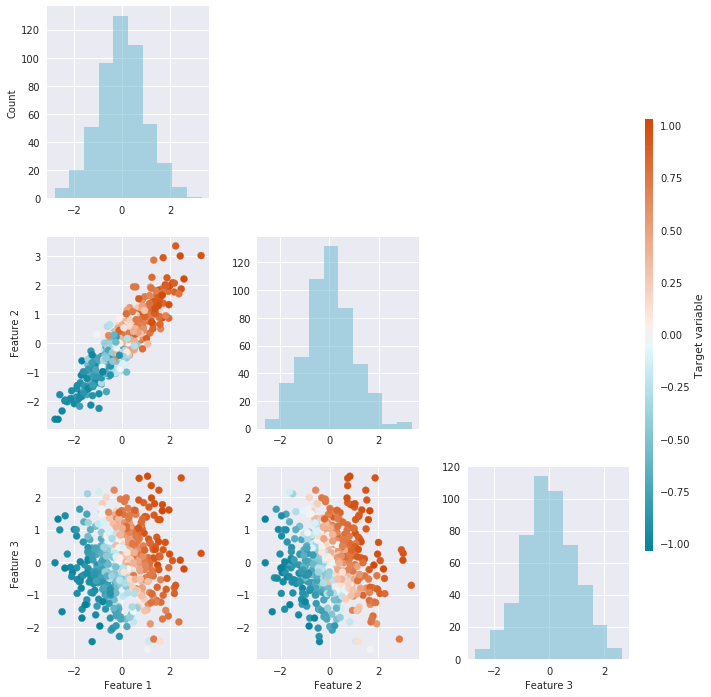

In [6]:
plot_all_data(X_corr, y_corr)

### Not correlated features

In [7]:
cov = np.array([[1, 0.07, 0.03], [0.07, 1, -0.1], [0.03, -0.1, 1]])

X, y = get_data(cov)

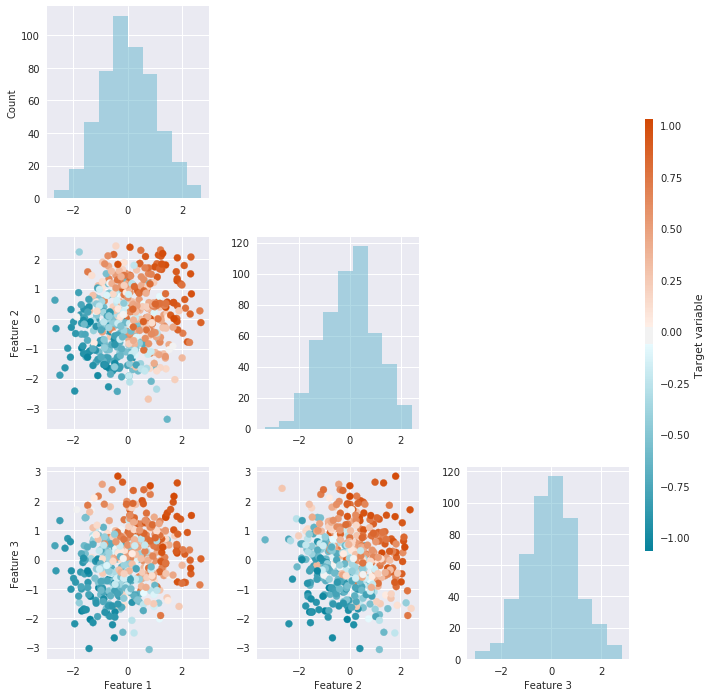

In [8]:
plot_all_data(X, y)

## Apply chain PCA -> EDR-GP for high correlated data

In [21]:
edr_prep = EffectiveDimensionalityReduction(GaussianProcessRegressor(),
                                            CustomPCA(), n_components=1,
                                            preprocessor=PCA(n_components=2))

edr = EffectiveDimensionalityReduction(GaussianProcessRegressor(),
                                       CustomPCA(), n_components=1)

In [22]:
edr_corr, edr_prep_cor = fit_models(X_corr, y_corr, edr, edr_prep)

In [23]:
def plot_diff(X, y, dr, dr_prep, title):  
    
    fig = plt.figure(figsize=[12, 5])
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(dr.transform(X), y, color=sns.color_palette()[1])
    ax.set_xlabel('Linear combination for raw data', fontsize=16)
    ax.set_ylabel('The target variable', fontsize=16)
    mi = mutual_info_regression(dr.transform(X), y)[0]
    txt = ('Mutual information beween the target and '
           'the found linear combination for raw data is {:.3f}'.format(mi))
    print(txt)
    
    plt.subplot(1, 2, 2)
    plt.suptitle(title, fontsize=18)
    plt.scatter(dr_prep.transform(X), y, color=sns.color_palette()[5])
    plt.xlabel('Linear combination for preprocessed data', fontsize=16)
    mi = mutual_info_regression(dr_prep.transform(X), y)[0]
    txt = ('Mutual information beween the target and '
             'the found linear combination for preprocessed '
             'data is {:.3f}'.format(mi))
    print(txt)

Mutual information beween the target and the found linear combination for raw data is 2.386
Mutual information beween the target and the found linear combination for preprocessed data is 2.389


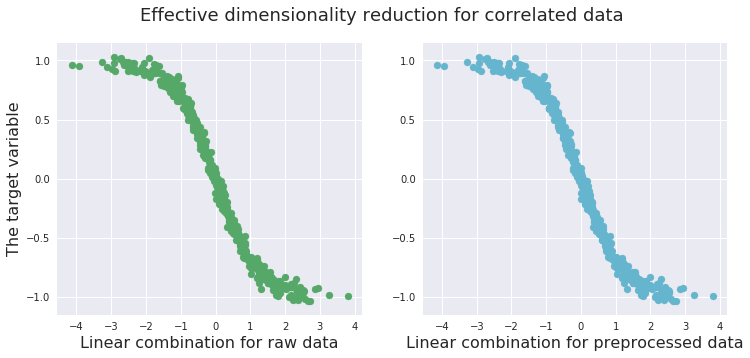

In [24]:
plot_diff(X_corr, y_corr, edr_corr, edr_prep_cor,
          'Effective dimensionality reduction for correlated data')

## Apply chain PCA -> EDR-GP for not correlated data

In [25]:
edr_raw, edr_prep_raw = fit_models(X, y, edr, edr_prep)

Mutual information beween the target and the found linear combination for raw data is 2.320
Mutual information beween the target and the found linear combination for preprocessed data is 1.228


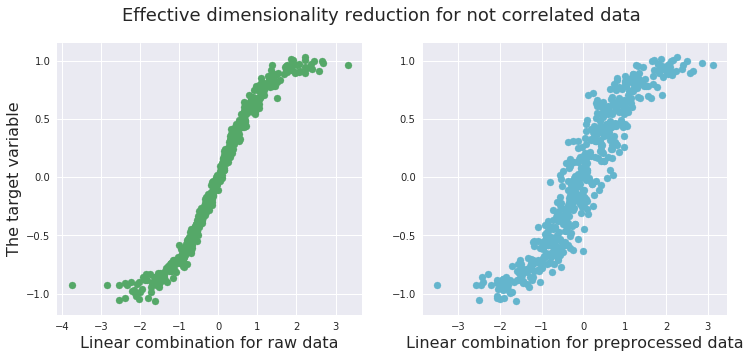

In [26]:
plot_diff(X, y, edr_raw, edr_prep_raw,
         'Effective dimensionality reduction for not correlated data')